# Training DNN with acoustic features
### Tutors: [Trung Ngo Trong](trung@imito.ai)

-----

## Loading libraries and dataset

### Why using DNN ?

![alt text](img/why_dnn.png "Title")

### Why using CNN ?

![alt text](img/why_cnn.png "Title")

### Why using RNN ?

![alt text](img/why_rnn.png "Title")

### Loading neccesary libraries

In [1]:
%matplotlib inline
from __future__ import print_function, absolute_import, division
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize
figsize(12, 4)

import os
os.environ['ODIN'] = 'float32,cpu,tensorflow'
import sys

import numpy as np
np.random.seed(1208)

from odin import nnet as N, backend as K, fuel as F
from odin.basic import has_roles, BIAS, WEIGHT
from odin.stats import train_valid_test_split, freqcount
from odin import training

/Users/trungnt13/libs/conda/envs/ai/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
[Auto-Config] Device : cpu
[Auto-Config] Multi-GPU : False
[Auto-Config] Backend: tensorflow
[Auto-Config] Optimizer: fast_run
[Auto-Config] FloatX : float32
[Auto-Config] Epsilon: 1e-07
[Auto-Config] CNMEM  : 0.0
[Auto-Config] SEED  : 1208251813


### Load the data

In [2]:
data_path = os.path.join(os.path.dirname(sys.argv[0]), 'data', 'sample1.wav')
ds = F.load_digit_audio()
print(ds)
nb_classes = 10 # 10 digits (0-9)

==========  Dataset:/Users/trungnt13/.odin/datasets/digit Total:64  ==========
README:
------
 All credits go to: Zohar Jackson (https://github.com/Jakobovski) for collecting all the data
 Original github repo: https://github.com/Jakobovski/free-spoken-digit-dataset
 For more information: /Users/trungnt13/.odin/datasets/digit/README.md
Data:
----
 Name:energy       dtype:float16      shape:(26139, 3)    file:/Users/trungnt13/.odin/datasets/digit/energy     
 Name:energy_mean  dtype:float64      shape:(3,)          file:/Users/trungnt13/.odin/datasets/digit/energy_mean
 Name:energy_pca   dtype:MiniBatchPCA shape:0             file:/Users/trungnt13/.odin/datasets/digit/energy_pca 
 Name:energy_std   dtype:float64      shape:(3,)          file:/Users/trungnt13/.odin/datasets/digit/energy_std 
 Name:energy_sum1  dtype:float64      shape:(3,)          file:/Users/trungnt13/.odin/datasets/digit/energy_sum1
 Name:energy_sum2  dtype:float64      shape:(3,)          file:/Users/trungnt13/.odin/

### Split and preprocessing data

In [3]:
indices = [(name, start, end) for name, (start, end) in ds['indices']]
longest_utterances = max(int(end) - int(start) - 1
                         for i, start, end in indices)
longest_vad = max(end - start
                  for name, vad in ds['vadids'] for (start, end) in vad)
print("Longest Utterance:", longest_utterances)
print("Longest Vad:", longest_vad)

np.random.shuffle(indices)
train, valid, test = train_valid_test_split(indices, train=0.6, inc_test=True)
print('Nb train:', len(train), freqcount([int(i[0][0]) for i in train]))
print('Nb valid:', len(valid), freqcount([int(i[0][0]) for i in valid]))
print('Nb test:', len(test), freqcount([int(i[0][0]) for i in test]))

train_feeder = F.Feeder(ds['mspec'], train, ncpu=1)
test_feeder = F.Feeder(ds['mspec'], test, ncpu=2)
valid_feeder = F.Feeder(ds['mspec'], valid, ncpu=2)

recipes = [
    F.recipes.Name2Trans(converter_func=lambda x: int(x[0])),
    F.recipes.Normalization(
        mean=ds['mspec_mean'],
        std=ds['mspec_std'],
        local_normalize=False
    ),
    F.recipes.Sequencing(frame_length=longest_utterances, hop_length=1,
                         end='pad', endvalue=0, endmode='post',
                         transcription_transform=lambda x: x[-1]),
    F.recipes.CreateFile()
]

train_feeder.set_recipes(recipes)
test_feeder.set_recipes(recipes)
valid_feeder.set_recipes(recipes)
print('Feature shape:', train_feeder.shape)
feat_shape = (None,) + train_feeder.shape[1:]

X = K.placeholder(shape=feat_shape, name='X')
y = K.placeholder(shape=(None,), dtype='int32', name='y')

Longest Utterance: 87
Longest Vad: 43
Nb train: 301 OrderedDict([(0, 26), (1, 37), (2, 28), (3, 30), (4, 27), (5, 31), (6, 32), (7, 31), (8, 34), (9, 25)])
Nb valid: 100 OrderedDict([(0, 13), (1, 7), (2, 12), (3, 10), (4, 15), (5, 9), (6, 5), (7, 9), (8, 8), (9, 12)])
Nb test: 100 OrderedDict([(0, 11), (1, 6), (2, 10), (3, 10), (4, 8), (5, 10), (6, 14), (7, 10), (8, 8), (9, 13)])
Feature shape: (302, 87, 120)


## Creating and training the network

### Creating a deep network

![alt text](img/thenetwork.png "Title")

In [4]:
f = N.Sequence([
    N.Dimshuffle(pattern=(0, 1, 2, 'x')),
    N.Conv(num_filters=32, filter_size=3, pad='same', strides=1,
           activation=K.linear),
    N.BatchNorm(activation=K.relu),
    N.Pool(pool_size=2, strides=None, pad='valid', mode='max'),
    N.Flatten(outdim=3),

    # ====== RNN ====== #
    N.AutoRNN(64, rnn_mode='lstm', num_layers=1,
              direction_mode='bidirectional', prefer_cudnn=True),

    # ====== Dense ====== #
    N.Flatten(outdim=2),
    # N.Dropout(level=0.2), # adding dropout does not help
    N.Dense(num_units=512, activation=K.relu),
    N.Dense(num_units=nb_classes, activation=K.softmax)
], debug=True)

K.set_training(True); y_train = f(X)
K.set_training(False); y_score = f(X)

# ====== create cost ====== #
cost_train = K.mean(K.categorical_crossentropy(y_train, y))
cost_test1 = K.mean(K.categorical_crossentropy(y_score, y))
cost_test2 = K.mean(K.categorical_accuracy(y_score, y))
cost_test3 = K.confusion_matrix(y_score, y, labels=range(10))

# ====== create optimizer ====== #
parameters = [p for p in f.parameters if has_roles(p, [WEIGHT, BIAS])]
optimizer = K.optimizers.RMSProp(lr=0.0001)

**************** Sequences: Sequence_yLd5NsDb ****************
Is training: True
First input: (None, 87, 120)
  <ops: Dimshuffle, name: Dimshuffle_JR3sJVEP, init: True> -> (None, 87, 120, 1)
  <ops: Conv, name: Conv_bAdsBAKH, init: True> -> (None, 87, 120, 32)
  <ops: BatchNorm, name: BatchNorm_KaggZ3xz, init: True> -> (None, 87, 120, 32)
  <ops: Pool, name: Pool_YhqoqUlS, init: True> -> (None, 43, 60, 32)
  <ops: Flatten, name: Flatten_K1b7T4SP, init: True> -> (None, 43, 1920)
  <ops: Sequence, name: Sequence_QDJOuPXY, init: True> -> (None, 43, 128)
  <ops: Flatten, name: Flatten_SlIT2zPI, init: True> -> (None, 5504)
  <ops: Dense, name: Dense_w16TnrK4, init: True> -> (None, 512)
  <ops: Dense, name: Dense_xt20NWQG, init: True> -> (None, 10)

**************** Sequences: Sequence_yLd5NsDb ****************
Is training: False
First input: (None, 87, 120)
  <ops: Dimshuffle, name: Dimshuffle_JR3sJVEP, init: True> -> (None, 87, 120, 1)
  <ops: Conv, name: Conv_bAdsBAKH, init: True> -> (Non

### Training the network

Building training functions ...
Building scoring functions ...
Name:valid   ,Epoch: 1,Results:0.1335;0.9904 100/100 [=======================================] - 1s     
Tracking name-"valid" at location-2:
[[13  0  0  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  1  0  0  0]
 [ 0  0 12  0  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0  0 15  0  0  0  0  0]
 [ 0  0  0  0  0  9  0  0  0  0]
 [ 0  0  0  0  0  0  5  0  0  0]
 [ 0  0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0  0  0  8  0]
 [ 0  0  0  0  0  0  0  0  0 12]]
Name:train   ,Epoch: 1,Results:0.6397;8.4701 100/100 [=======================================] - 21s    
Name:valid   ,Epoch: 2,Results:0.0559;0.9904 100/100 [=======================================] - 1s     
Tracking name-"valid" at location-2:
[[13  0  0  0  0  0  0  0  0  0]
 [ 0  6  1  0  0  0  0  0  0  0]
 [ 0  0 12  0  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0  0 15  0  0  0  0  0]
 [ 0  0  0  0  0  9  0  0  0  0]
 [ 0  0  0  0  0  0

/Users/trungnt13/libs/odin/odin/training/__init__.py:221: RuntimeWarning: invalid value encountered in true_divide
  y = (y - y.min()) / (y.max() - y.min())


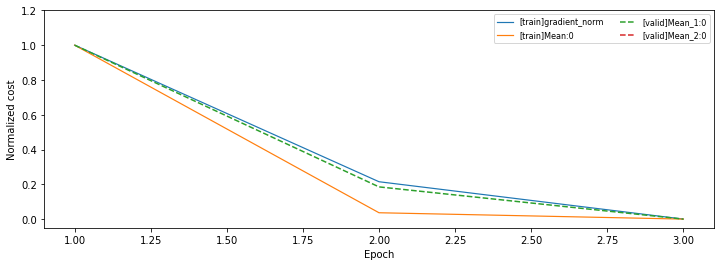

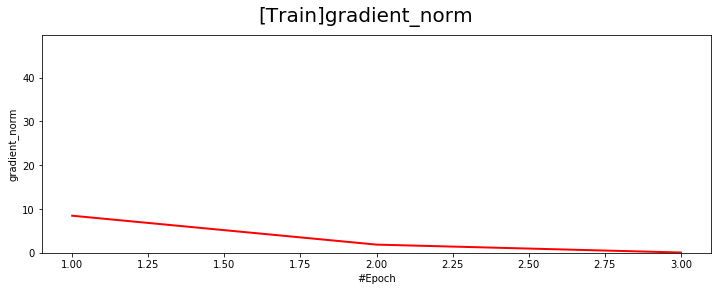

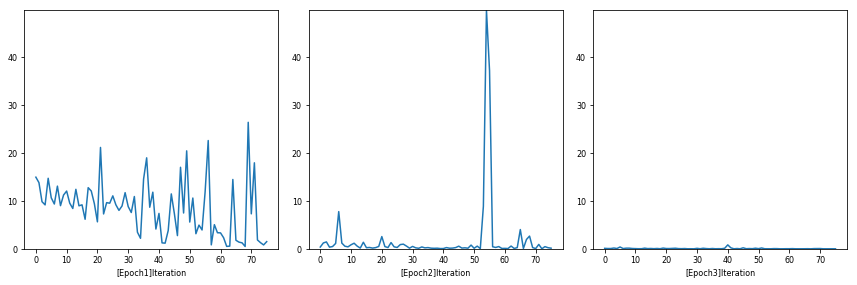

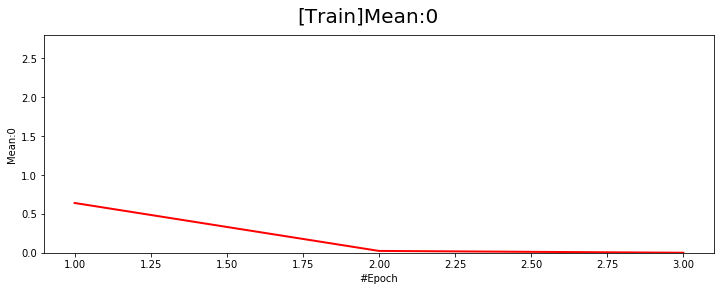

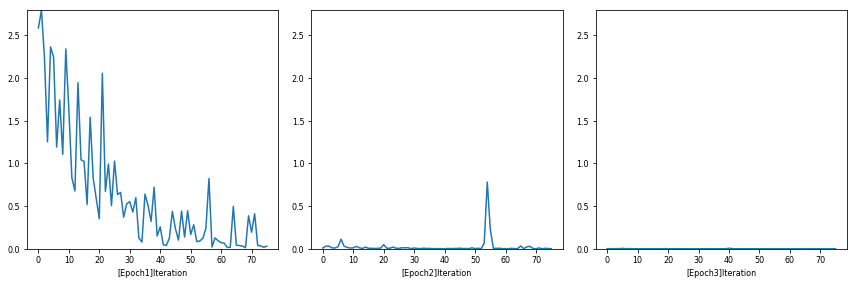

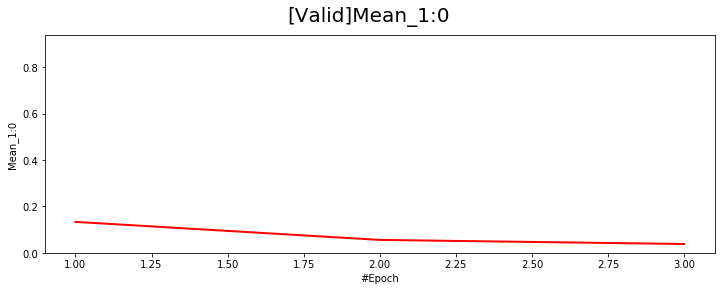

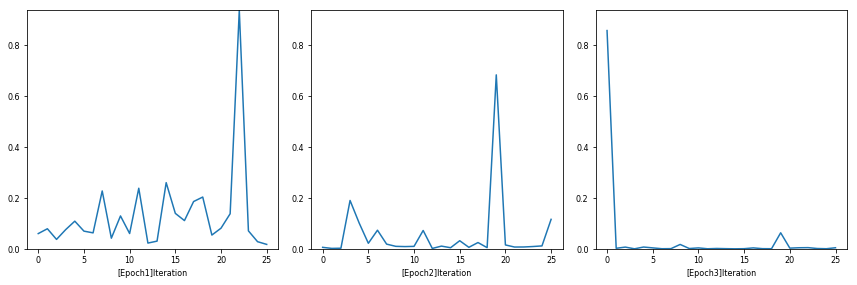

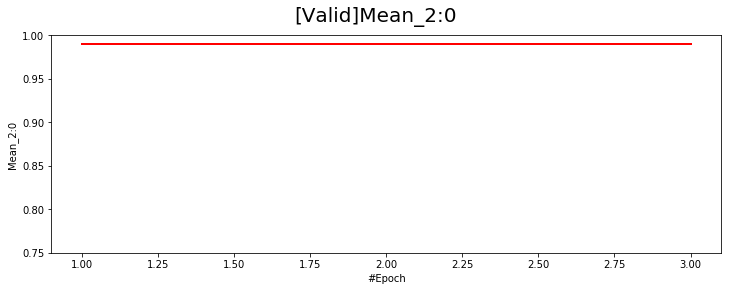

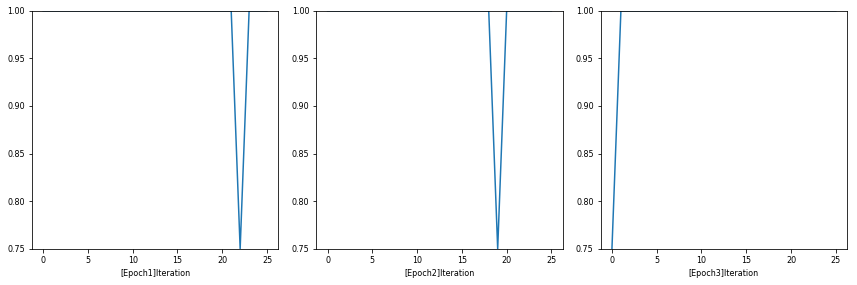

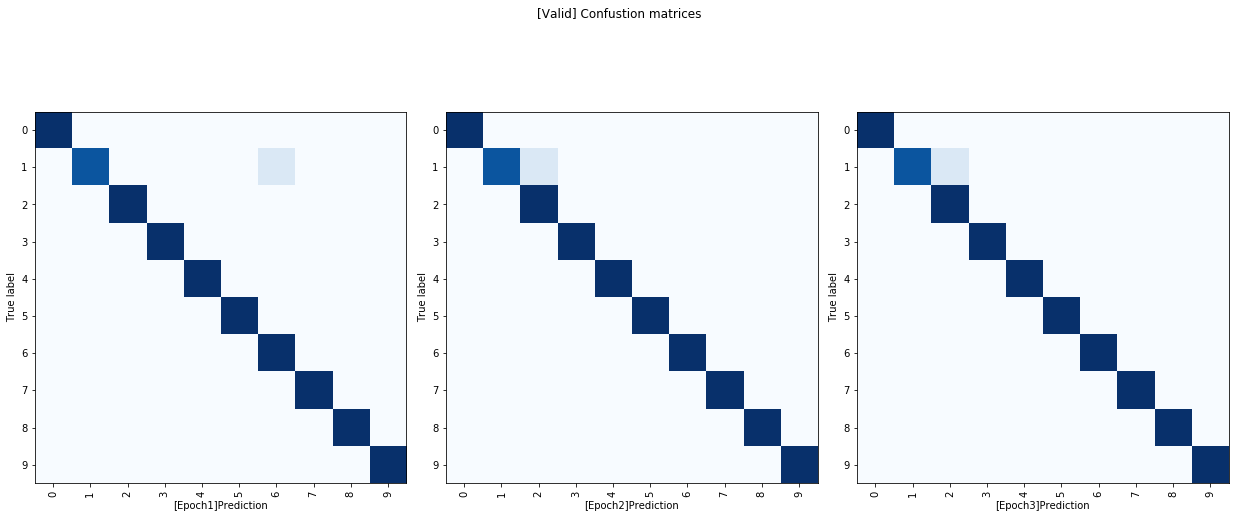

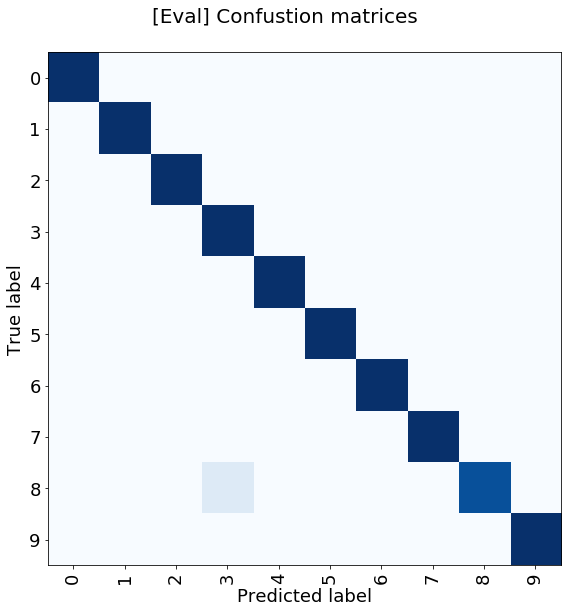

In [5]:
trainer, hist = training.standard_trainer(
    train_data=train_feeder, valid_data=valid_feeder, test_data=test_feeder,
    cost_train=cost_train, cost_score=[cost_test1, cost_test2], cost_regu=None,
    parameters=parameters, optimizer=optimizer,
    confusion_matrix=cost_test3, gradient_norm=True,
    batch_size=4, nb_epoch=3, valid_freq=0.8,
    save_path=None, save_obj=None,
    report_path='show',
    enable_rollback=True, stop_callback=None, save_callback=None,
    labels=None
)
trainer.run()